# Data exploration of the CFIS-W3 lensing catalog

In this notebook, we are using the non-public data of the **full CFIS-W3 field** (50 deg^2) provided elsewhere.

In [1]:
%pylab inline
%config Completer.use_jedi = False

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np

## 1st session
07/10/2021

Look at some basic quantities in catalogue (positions, flags, magnitude, ...)

In [3]:
# Load catalogue (numpy file)
dd = np.load('./catalogue_CFIS_W3/final_cat.npy')

**SExtractor denominations:**

- XWIN_WORLD: RA
- YWIN_WORLD: DEC

Shape measurement is done with two methods
- ngmix (preferred): model fitting (mixture of gaussians) on multi-epoch images, easy to process metacalibration with it
- galsim (depreciated): quadrupole moment measurements on stacks, shear estimate looks very biases probably due to inaccurate stacked PSF model

In [4]:
# Show column names
print(dd.dtype.names)

('XWIN_WORLD', 'YWIN_WORLD', 'TILE_ID', 'FLAGS', 'IMAFLAGS_ISO', 'NGMIX_MCAL_FLAGS', 'NGMIX_ELL_PSFo_NOSHEAR', 'GALSIM_PSF_ELL_ORIGINAL_PSF', 'SPREAD_CLASS', 'SPREAD_MODEL', 'SPREADERR_MODEL', 'N_EPOCH', 'NGMIX_N_EPOCH', 'NGMIX_ELL_1M', 'NGMIX_ELL_1P', 'NGMIX_ELL_2M', 'NGMIX_ELL_2P', 'NGMIX_ELL_NOSHEAR', 'NGMIX_ELL_ERR_NOSHEAR', 'NGMIX_FLAGS_1M', 'NGMIX_FLAGS_1P', 'NGMIX_FLAGS_2M', 'NGMIX_FLAGS_2P', 'NGMIX_FLAGS_NOSHEAR', 'NGMIX_T_1M', 'NGMIX_T_1P', 'NGMIX_T_2M', 'NGMIX_T_2P', 'NGMIX_T_NOSHEAR', 'NGMIX_T_ERR_1M', 'NGMIX_T_ERR_1P', 'NGMIX_T_ERR_2M', 'NGMIX_T_ERR_2P', 'NGMIX_T_ERR_NOSHEAR', 'NGMIX_Tpsf_1M', 'NGMIX_Tpsf_1P', 'NGMIX_Tpsf_2M', 'NGMIX_Tpsf_2P', 'NGMIX_Tpsf_NOSHEAR', 'NGMIX_FLUX_1M', 'NGMIX_FLUX_1P', 'NGMIX_FLUX_2M', 'NGMIX_FLUX_2P', 'NGMIX_FLUX_NOSHEAR', 'NGMIX_FLUX_ERR_1M', 'NGMIX_FLUX_ERR_1P', 'NGMIX_FLUX_ERR_2M', 'NGMIX_FLUX_ERR_2P', 'NGMIX_FLUX_ERR_NOSHEAR', 'GALSIM_GAL_ELL_1M', 'GALSIM_GAL_ELL_1P', 'GALSIM_GAL_ELL_2M', 'GALSIM_GAL_ELL_2P', 'GALSIM_GAL_ELL_NOSHEAR', 'GAL

How many objects do we have?

In [5]:
len(dd)

5367032

Map the distribution of objects on the sky

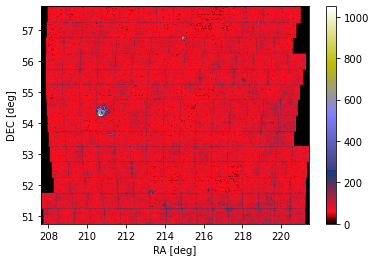

In [6]:
hist2d(dd['XWIN_WORLD'], dd['YWIN_WORLD'], 256, cmap='gist_stern');
xlabel('RA [deg]')
ylabel('DEC [deg]')
_ = colorbar()

Apply some masking to the catalog

In [7]:
# FLAG_TILING = 0: duplicate objects due to overlapping tiles
# FLAGS != 0: SExtractor mask
# IMAFLAGS_ISO != 0: masked objects (bright stars, Messier objects, chip defects, ...)
# NGMIX_ELL_NOSHEAR = -10: invalid measurement (e.g. invalid PSF)
# NGMIX_FLAGS_NOSHEAR != 1: failed shape measurement

# mask = (dd['FLAG_TILING'] == 1) & (dd['FLAGS']==0) \
#   & (dd['IMAFLAGS_ISO'] == 0) \
#   & (dd['NGMIX_ELL_NOSHEAR'][:,0] > -10) \
#   & (dd['NGMIX_FLAGS_NOSHEAR'] != 1)[0]


# Trying out this mask
mask = (dd['FLAG_TILING'] == 1) & (dd['FLAGS'] == 0) & (dd['IMAFLAGS_ISO'] == 0) & \
        (dd['NGMIX_FLAGS_NOSHEAR'] == 0) &  (dd['NGMIX_MCAL_FLAGS'] == 0)

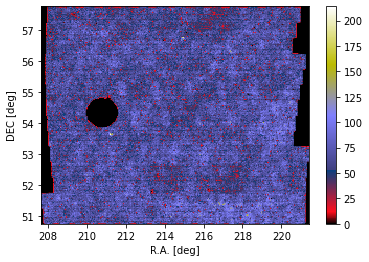

In [8]:
hist2d(dd['XWIN_WORLD'][mask], dd['YWIN_WORLD'][mask], 256, cmap='gist_stern');
xlabel('R.A. [deg]')
ylabel('DEC [deg]')
_ = colorbar()

r band magnitude distribution

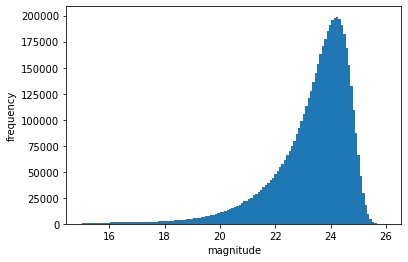

In [9]:
hist(dd['MAG_AUTO'], range=(15,26), bins=128);
_ = xlabel('magnitude')
_ = ylabel('frequency')

r band SNR distribution

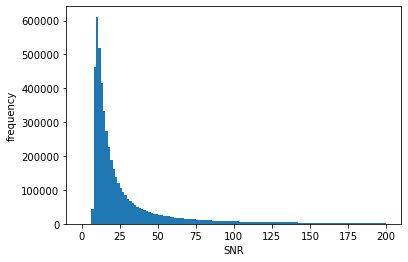

In [10]:
hist(dd['SNR_WIN'], range=(0,200), bins=128);
_ = xlabel('SNR')
_ = ylabel('frequency')

Mean ellipticity

In [11]:
print(dd['NGMIX_ELL_NOSHEAR'].shape)
print('mean e1', np.mean(dd['NGMIX_ELL_NOSHEAR'][:,0][mask]))
print('mean e2', np.mean(dd['NGMIX_ELL_NOSHEAR'][:,1][mask]))

(5367032, 2)
mean e1 -0.0005714872916208202
mean e2 0.0004328348554080995


## 2nd session
14/10/2021

Explore in more detail galaxy selection.

Load star catalogue.

SPREAD_CLASS classification

(Depreciated, we will use SPREAD_MODEL later.)

Note that only galaxies will be selected on the stacks. Stars have been detected on the single exposures, this provides a more homogeneous star sample. We will look at the (validation) star catalogue later.

0: stars
1: galaxies
2: artefacts

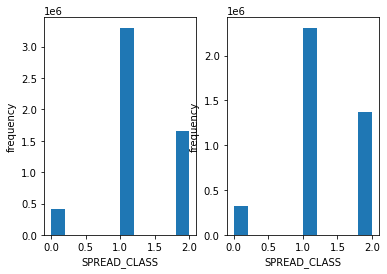

In [12]:
# Plot distribution
subplot(121)
_ = hist(dd['SPREAD_CLASS'])
_ = xlabel('SPREAD_CLASS')
_ = ylabel('frequency')

subplot(122)
_ = hist(dd['SPREAD_CLASS'][mask])
_ = xlabel('SPREAD_CLASS')
_ = ylabel('frequency')

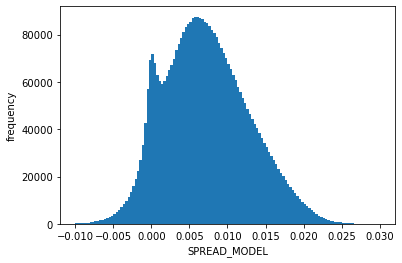

In [13]:
# Preferred classification: SPREAD_MODEL
# See SExtractor documentation https://sextractor.readthedocs.io/en/latest/Model.html#model-based-star-galaxy-separation-spread-model
# Here, this flag is computed by the ShapePipe implementation of the spread model

# Plot distribution
_ = hist(dd['SPREAD_MODEL'][mask], range=[-0.01, 0.03], bins=128)
_ = xlabel('SPREAD_MODEL')
_ = ylabel('frequency')

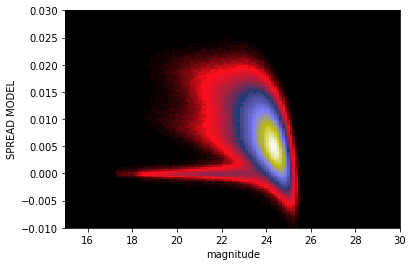

In [14]:
# Typically, one plots the 2D distribution of magnitude and spread model, to identify the *stellar locus*, i.e.
# a number of objects with more or less the same size

_ = hist2d(dd['MAG_AUTO'][mask], dd['SPREAD_MODEL'][mask], range=[[15, 30], [-0.01, 0.03]],
           bins=128, cmap='gist_stern')
_ = xlabel('magnitude')
_ = ylabel('SPREAD MODEL')

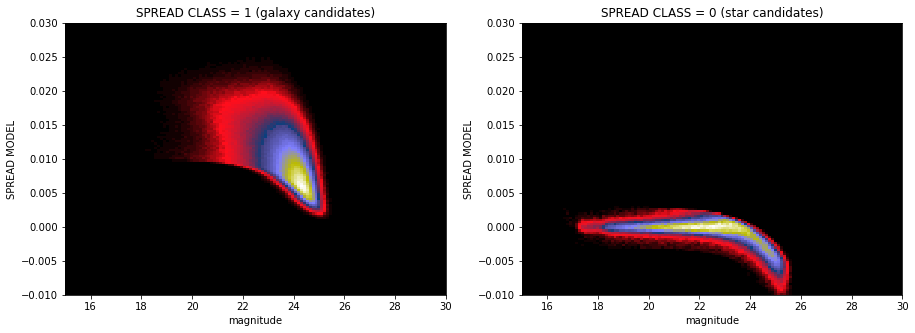

In [15]:
# See whether we can better see the galaxy and star distribution when splitting the data
# according to SPREAD_CLASS

mask_galaxies = mask & (dd['SPREAD_CLASS']==1)

figure(figsize=[15,5])
subplot(121)
_ = hist2d(dd['MAG_AUTO'][mask_galaxies], dd['SPREAD_MODEL'][mask_galaxies], range=[[15, 30], [-0.01, 0.03]],
           bins=128, cmap='gist_stern')
_ = xlabel('magnitude')
_ = ylabel('SPREAD MODEL')
_ = title('SPREAD CLASS = 1 (galaxy candidates)')

mask_stars = mask & (dd['SPREAD_CLASS']==0)

subplot(122)
_ = hist2d(dd['MAG_AUTO'][mask_stars], dd['SPREAD_MODEL'][mask_stars], range=[[15, 30], [-0.01, 0.03]],
           bins=128, cmap='gist_stern')
_ = xlabel('magnitude')
_ = ylabel('SPREAD MODEL')
_ = title('SPREAD CLASS = 0 (star candidates)')

### Look at (validation) star catalog
The PSF model was created using stars detected and selected on single-exposure images. In fact, a random sub-set of 80% of all stars was used to create the PSF model, 20% are kept as vaidation set, which we willl look at here.

The validation stars are stored in a separate file, which is the union of all single-exposure selected validation stars.

#### Two methods to load fits table

In [16]:
from astropy.io import fits
star_path = './catalogue_CFIS_W3/output/run_sp_MsPl/mccd_merge_starcat_runner/output/full_starcat-0000000.fits'

In [17]:
stars_cat = fits.getdata(star_path)

In [18]:
from astropy.table import Table

In [19]:
stars_cat = Table.read(star_path, hdu=2)

In [20]:
stars_cat

X,Y,RA,DEC,E1_PSF_HSM,E2_PSF_HSM,SIGMA_PSF_HSM,E1_STAR_HSM,E2_STAR_HSM,SIGMA_STAR_HSM,FLAG_PSF_HSM,FLAG_STAR_HSM,CCD_NB
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-5655.071395124369,5279.214739098517,217.82663582087287,54.77844259649623,0.06664546013000466,-0.049135098381858304,1.5797637701034546,0.060129399125684754,-0.034367393753435414,1.5556344985961914,0.0,0.0,0.0
-5343.009734439577,5704.926691200415,217.7987110599747,54.80043341126079,0.05792693309369971,-0.04129280830916392,1.5584254264831543,0.08364215624866449,-0.037897859360399966,1.5426160097122192,0.0,0.0,0.0
-5678.412263601143,9409.454217525388,217.82782104440528,54.99042946287721,0.04776511477621796,-0.0836767702194216,1.6429502964019775,0.003825565889885061,-0.05474192806394717,1.59054434299469,0.0,0.0,0.0
-6025.913945265132,7109.661388612281,217.8593681367769,54.87222335981904,0.058715833563876,-0.04180727255062146,1.5368461608886719,0.0748434025323804,-0.05335470965185339,1.5682880878448486,0.0,0.0,0.0
-5496.535703385833,7689.441284959215,217.81193326280484,54.902227985021945,0.06050961556375801,-0.0506556021889481,1.5530987977981567,0.048600848111630075,-0.02515582568472467,1.5489903688430786,0.0,0.0,0.0
-5667.527799305658,5639.927007733217,217.8276678998636,54.79695198096755,0.06186273096054109,-0.04461564301400481,1.564837098121643,0.06751784269856966,-0.03727211997310413,1.519326090812683,0.0,0.0,0.0
-4862.05607217563,7799.660170079584,217.75516888878155,54.90815543920137,0.06587982079167724,-0.053426953095139645,1.5588291883468628,0.05576049660420453,-0.04439083898283978,1.5419180393218994,0.0,0.0,0.0
-4860.3028857939435,6688.294107323913,217.7553559760284,54.85111160455157,0.054721920209811314,-0.036955862472197606,1.5364415645599365,0.060815959990342984,-0.03994012522109251,1.5554977655410767,0.0,0.0,1.0
-5846.117157971118,8876.389931656708,217.8429543299225,54.96299104565496,0.03561304503848562,-0.059874500100288754,1.5912493467330933,0.04172981776170023,-0.042188382093558664,1.5612646341323853,0.0,0.0,1.0


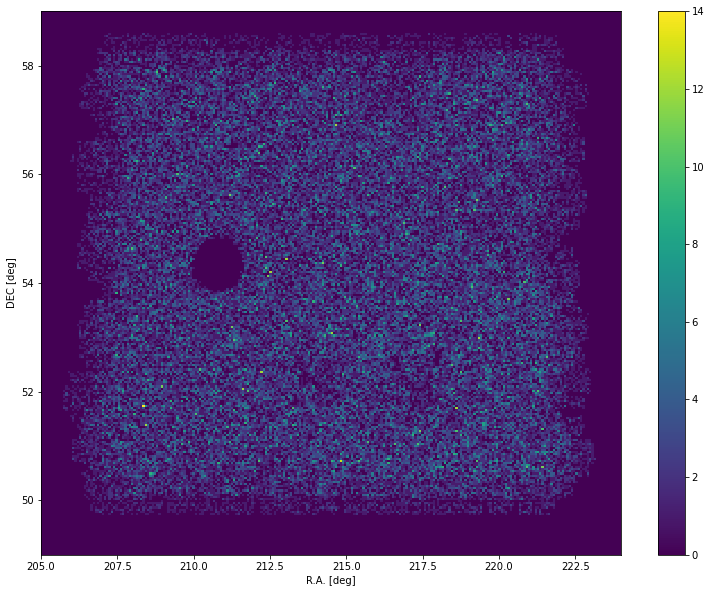

In [21]:
# Plot spatial distribution
# Patterns can be seen that reflect the survey strategy of using large dithers. A given star appears on
# typically three exposures with varying PSF, since the position in the focal plane as well as the
# observing conditions change. The number of exposures also varies. In particular at the borders of the field
# we can see this decreased depth, and also the geometry of the MegaCAM CCD mosaic with the 4 new "ear" CCDs.

figure(figsize=(13,10))
hist2d(stars_cat['RA'], stars_cat['DEC'], range=[[205, 224], [49, 59]], bins=256);
_ = colorbar()
_ = xlabel('R.A. [deg]')
_ = ylabel('DEC [deg]')

## 3rd session
21/10/2021

Calculate the response matrix R for galaxies and stars

In [22]:
# Refine the mask from the last sessions, to correctly select the galaxies

# Rule: sm_classif > 0.0035
sm_classif = dd['SPREAD_MODEL'] + 2 * dd['SPREADERR_MODEL']
selected_gals = sm_classif > 0.0035


# The size of the galaxy measured by ngmix is the size of the galaxy after the deconvolution
# by the PSF. Mask proposed by Axel.
size_mask = (dd['NGMIX_T_NOSHEAR'] / dd['NGMIX_Tpsf_NOSHEAR']) > 0.5

mask_spread_mod = mask & (selected_gals) & (dd['SPREAD_MODEL'] > 0) & (size_mask)

/Users/tliaudat/opt/anaconda3/envs/WF_PSF/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [23]:
### Response matrix for galaxies

Mean(R11) =  0.6186325650470758
Mean(R12) =  -0.00038264528300505676
Mean(R21) =  -4.624142891512218e-05
Mean(R22) =  0.6122851915964442
[[ 6.18632565e-01 -3.82645283e-04]
 [-4.62414289e-05  6.12285192e-01]]


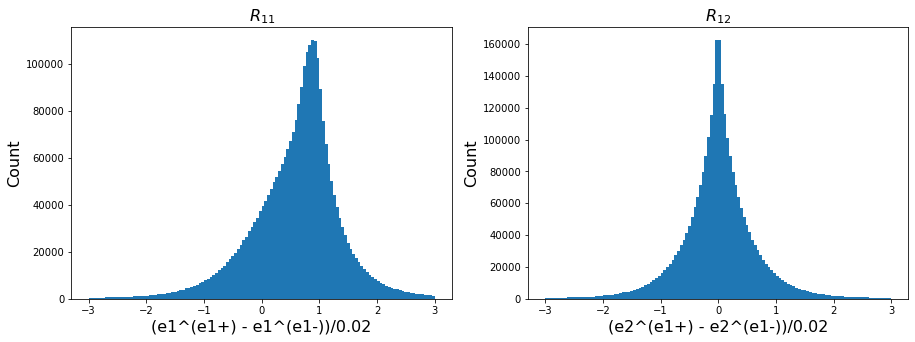

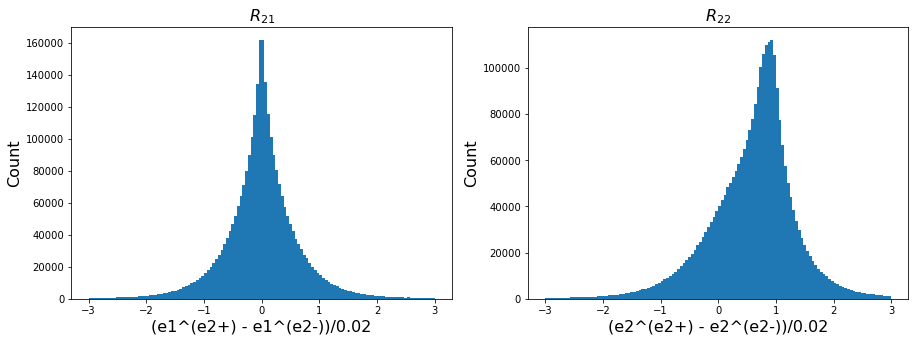

In [24]:
# Response matrix:
# Rij = del[ellipticity_i] / del[shear_j]
#     = change of observed elipticity component #i with respect to shear component #j

# Compute all four matrix elements with finite differences.
# Added shear:
dg = 0.01
R11 = (dd['NGMIX_ELL_1P'][mask_spread_mod][:,0] - dd['NGMIX_ELL_1M'][mask_spread_mod][:,0]) / (2 * dg)
R12 = (dd['NGMIX_ELL_1P'][mask_spread_mod][:,1] - dd['NGMIX_ELL_1M'][mask_spread_mod][:,1]) / (2 * dg)

R22 = (dd['NGMIX_ELL_2P'][mask_spread_mod][:,1] - dd['NGMIX_ELL_2M'][mask_spread_mod][:,1]) / (2 * dg)
R21 = (dd['NGMIX_ELL_2P'][mask_spread_mod][:,0] - dd['NGMIX_ELL_2M'][mask_spread_mod][:,0]) / (2 * dg)

range = [-3, 3]
nbins = 126
size = 16

fig = figure(figsize=(15, 5))
subplot(121)
_ = hist(R11, bins=nbins, range=range)
_ = xlabel(f'(e1^(e1+) - e1^(e1-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{11}$', size=size)

subplot(122)
_ = hist(R12, bins=nbins, range=range)
_ = xlabel(f'(e2^(e1+) - e2^(e1-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{12}$', size=size)


fig = figure(figsize=(15, 5))
subplot(121)
_ = hist(R21, bins=nbins, range=range)
_ = xlabel(f'(e1^(e2+) - e1^(e2-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{21}$', size=size)


subplot(122)
_ = hist(R22, bins=nbins, range=range)
_ = xlabel(f'(e2^(e2+) - e2^(e2-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{22}$', size=size)


print('Mean(R11) = ', np.mean(R11))
print('Mean(R12) = ', np.mean(R12))
print('Mean(R21) = ', np.mean(R21))
print('Mean(R22) = ', np.mean(R22))

R_gal = np.array([[np.mean(R11), np.mean(R12)], [np.mean(R21), np.mean(R22)]])
print(R_gal)

### Response matrix for stars

In [25]:
# Create mask to select stars

mask_stars = mask & (dd['SPREAD_CLASS']==0)

Mean(R11_stars) =  0.17426761654817355
Mean(R12_stars) =  0.0008290025792978885
Mean(R21_stars) =  0.007173902756103036
Mean(R22_stars) =  0.16256382972703953


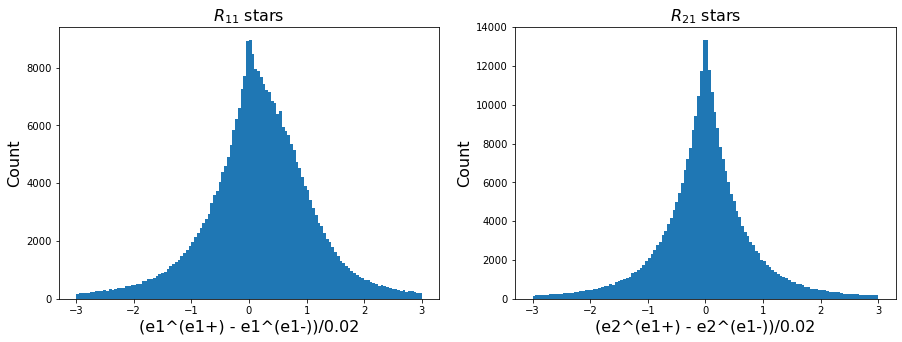

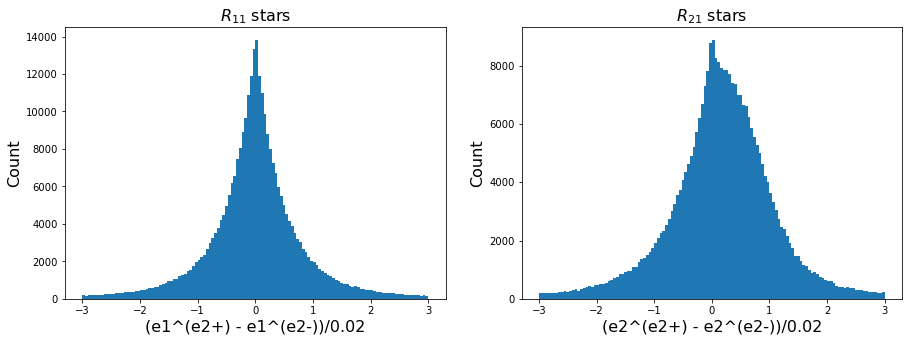

In [26]:
R11_stars = (dd['NGMIX_ELL_1P'][mask_stars][:,0] - dd['NGMIX_ELL_1M'][mask_stars][:,0]) / (2 * dg)
R12_stars = (dd['NGMIX_ELL_1P'][mask_stars][:,1] - dd['NGMIX_ELL_1M'][mask_stars][:,1]) / (2 * dg)

R22_stars = (dd['NGMIX_ELL_2P'][mask_stars][:,1] - dd['NGMIX_ELL_2M'][mask_stars][:,1]) / (2 * dg)
R21_stars = (dd['NGMIX_ELL_2P'][mask_stars][:,0] - dd['NGMIX_ELL_2M'][mask_stars][:,0]) / (2 * dg)

fig = figure(figsize=(15, 5))
subplot(121)
_ = hist(R11_stars, bins=126, range=range)
_ = xlabel(f'(e1^(e1+) - e1^(e1-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{11}$ stars', size=size)

subplot(122)
_ = hist(R12_stars, bins=126, range=range)
_ = xlabel(f'(e2^(e1+) - e2^(e1-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{21}$ stars', size=size)


fig = figure(figsize=(15, 5))
subplot(121)
_ = hist(R21_stars, bins=126, range=range)
_ = xlabel(f'(e1^(e2+) - e1^(e2-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{11}$ stars', size=size)

subplot(122)
_ = hist(R22_stars, bins=126, range=range)
_ = xlabel(f'(e2^(e2+) - e2^(e2-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{21}$ stars', size=size)


print('Mean(R11_stars) = ', np.mean(R11_stars))
print('Mean(R12_stars) = ', np.mean(R12_stars))
print('Mean(R21_stars) = ', np.mean(R21_stars))
print('Mean(R22_stars) = ', np.mean(R22_stars))

## 4th session
28/10/2021

Compute $\rho$ statistics to quantify errors in PSF model

Install `treecorr` and `Stile`
```
pip install treecorr
pip install git+https://github.com/tobias-liaudat/Stile
```

In [27]:
import treecorr
import stile
print("treecorr:" ,treecorr.__version__)
print("Stile: @tobias-liaudat's fork")

treecorr: 4.2.6
Stile: @tobias-liaudat's fork


In [28]:
# Create Rho1 test object
rho1_test = stile.CorrelationFunctionSysTest('Rho1')

In [29]:
# Show quantities that need to be assigned for rho1 correlation computation
rho1_test.required_quantities

[('ra', 'dec', 'g1', 'g2', 'psf_g1', 'psf_g2', 'w')]

In [30]:
# We do not have floating point weights for stars. Here
# we just use binary weights to remove flagged and masked objects.

star_flags = stars_cat['FLAG_STAR_HSM']
psf_flags = stars_cat['FLAG_PSF_HSM']
w = np.abs(star_flags - 1) * np.abs(psf_flags - 1)

In [31]:
import astropy.units as u

In [32]:
# Create Table with required quantities
stilecat = Table({'ra':stars_cat['RA'], 'dec':stars_cat['DEC'],
                 'g1':stars_cat['E1_STAR_HSM'], 'g2':stars_cat['E2_STAR_HSM'],
                 'psf_g1':stars_cat['E1_PSF_HSM'], 'psf_g2':stars_cat['E2_PSF_HSM'],
                 'w':w})

In [33]:
# Create TreeCorr configuration

sep_units = 'arcmin'
TreeCorrConfig = {
        'ra_units': 'degrees',
        'dec_units': 'degrees',
        'max_sep': '3e2',
        'min_sep': 5e-1,
        'sep_units': sep_units,
        'nbins': 32
    }

In [34]:
# Compute rho statistics rho_1
results = rho1_test(stilecat, config=TreeCorrConfig)

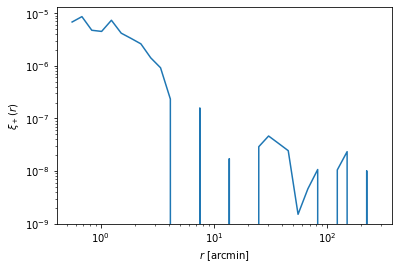

In [35]:
_ = loglog(results['meanr'], results['xip'])
_ = plt.xlabel(f'$r$ [{sep_units}]')
_ = plt.ylabel(r'$\xi_+(r)$')

In [36]:
# Compute with different output separation units
sep_units = 'degrees'
TreeCorrConfig = {
        'ra_units': 'degrees',
        'dec_units': 'degrees',
        'max_sep': '1',
        'min_sep': 5e-2,
        'sep_units': sep_units,
        'nbins': 20

}

In [37]:
results = rho1_test(stilecat, config=TreeCorrConfig)

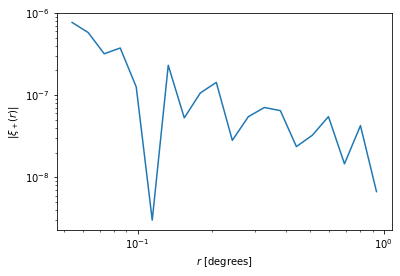

In [38]:
_ = loglog(results['meanr'], abs(results['xip']))
_ = plt.xlabel(f'$r$ [{sep_units}]')
_ = plt.ylabel(r'$|\xi_+(r)|$')

## 5th session
04/11/2021

Compute object-wise leakage between PSF and galaxy ellipticities, using some rough estimates.

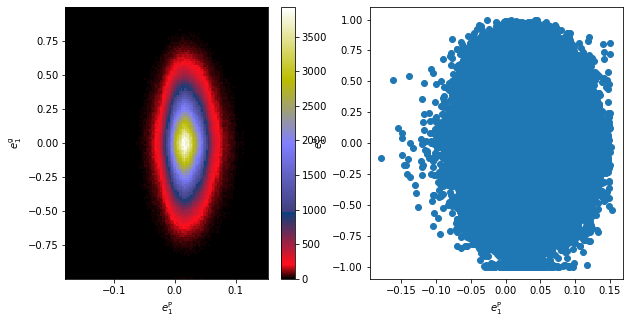

In [39]:
# Plot PSF versus galaxy elliptities.
# Use PSF interpolated to galaxy positions, thus extract PSF
# ellipticity from galaxy catalogue

gal_e = dd['NGMIX_ELL_NOSHEAR'][mask_spread_mod]
psf_e = dd['NGMIX_ELL_PSFo_NOSHEAR'][mask_spread_mod]

figure(figsize=(10,5))

subplot(121)
hist2d(psf_e[:,0], gal_e[:,0], bins=128, cmap='gist_stern');
colorbar()
xlabel(r'$e_1^{{\rm P}}$')
ylabel(r'$e_1^{{\rm g}}$')


subplot(122)
scatter(psf_e[:,0], gal_e[:,0])
xlabel(r'$e_1^{{\rm P}}$')
_ = ylabel(r'$e_1^{{\rm g}}$')

In [40]:
# By eye, it does not look as if there is a correlation in the plot.
# Let us fit a straight line to quantify this.

from scipy.optimize import curve_fit

def lin(x, a, b):
    return a*x + b

results, cov = curve_fit(lin, psf_e[:,0], gal_e[:,0])

In [41]:
a_best, b_best = results
print(f'Best-fit slope     a = {a_best:.3g}')
print(f'Best-fit intercept b = {b_best:.3g}')

Best-fit slope     a = -0.0108
Best-fit intercept b = -3.77e-05


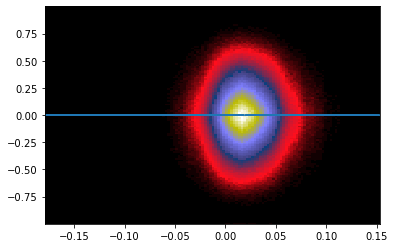

In [42]:
hist2d(psf_e[:,0], gal_e[:,0], bins=128, cmap='gist_stern');
plot(psf_e[:,0], lin(psf_e[:,0], results[0], results[1]))

In [43]:
# The intercept should in principle be close to the mean galaxy ellipcitiy.
# Check:
print('mean e1', np.mean(dd['NGMIX_ELL_NOSHEAR'][:,0][mask_spread_mod]))
print('mean e2', np.mean(dd['NGMIX_ELL_NOSHEAR'][:,1][mask_spread_mod]))

mean e1 -0.000256217876561979
mean e2 0.00037109044814758965


In [44]:
# Not far off!

# The slope is 1%, which means that the leakage is small.

In [45]:
np.sqrt(np.diag(cov))

array([0.00670006, 0.00020267])

Leakage e_1^P -> e_1^g
[-1.07761637e-02 -3.76958289e-05]
Leakage e_1^P -> e_2^g
[-0.00075798  0.00038646]
Leakage e_2^P -> e_1^g
[ 0.01166949 -0.00032102]
Leakage e_1^P -> e_2^g
[-0.00948852  0.00042378]


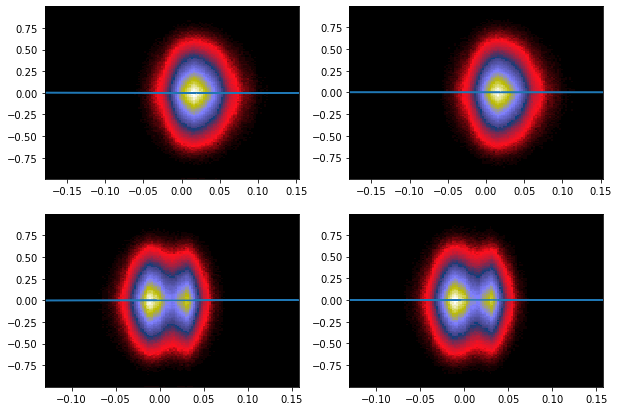

In [46]:
# Fit and plot all combinations of components

figure(figsize=[10,7])

subplot(221)
hist2d(psf_e[:,0], gal_e[:,0], bins=128, cmap='gist_stern');
results, cov = curve_fit(lin, psf_e[:,0], gal_e[:,0])
plot(psf_e[:,0], lin(psf_e[:,0], results[0], results[1]))
print(r'Leakage e_1^P -> e_1^g')
print(results)

subplot(222)
hist2d(psf_e[:,0], gal_e[:,1], bins=128, cmap='gist_stern');
results, cov = curve_fit(lin, psf_e[:,0], gal_e[:,1])
plot(psf_e[:,0], lin(psf_e[:,0], results[0], results[1]))
print(r'Leakage e_1^P -> e_2^g')
print(results)

subplot(223)
hist2d(psf_e[:,1], gal_e[:,0], bins=128, cmap='gist_stern');
results, cov = curve_fit(lin, psf_e[:,1], gal_e[:,0])
plot(psf_e[:,1], lin(psf_e[:,1], results[0], results[1]))
print(r'Leakage e_2^P -> e_1^g')
print(results)

subplot(224)
hist2d(psf_e[:,1], gal_e[:,1], bins=128, cmap='gist_stern');
results, cov = curve_fit(lin, psf_e[:,1], gal_e[:,1])
plot(psf_e[:,1], lin(psf_e[:,1], results[0], results[1]))
print(r'Leakage e_1^P -> e_2^g')
print(results)

In [47]:
# The cross-component leakage is very small, which is great.

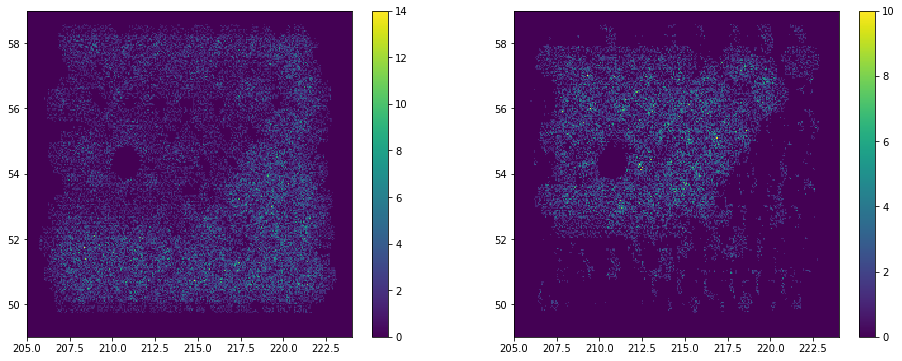

In [48]:
# Examine the strange bi-modality in e_2^P.
# See whether there is a spatial dependency.

figure(figsize=(16,6))
subplot(121)
mask_e2 = stars_cat['E2_PSF_HSM'] > 0.
hist2d(stars_cat['RA'][mask_e2], stars_cat['DEC'][mask_e2], range=[[205, 224], [49, 59]], bins=256);
colorbar()

subplot(122)
mask_e2 = stars_cat['E2_PSF_HSM'] < 0.
hist2d(stars_cat['RA'][mask_e2], stars_cat['DEC'][mask_e2], range=[[205, 224], [49, 59]], bins=256);
_ = colorbar()

In [49]:
# Yes! Positive and negative PSF ellipticty (component 2) are clearly separated spatially.
# This might come from the observing conditions and stratgey.

# 6th session

25/11/2021

Compute scale-dependent leakage function $\alpha(\theta)$.
This function is defined as follows.

$$
    \alpha(\theta) = \frac{\xi_{+}^{\rm gP}(\theta) - \langle e^{\rm g} \rangle^{*} \langle e^{\rm P} \rangle}{\xi_{+}^{\rm PP}(\theta) - |\langle e^{\rm P} \rangle|^{2}}
$$

With g = galaxy and P = PSF.

In [50]:
# So, first let up compute the galaxy - PSF cross-correlation function xi_+^{gP}.
# Use TreeCorr

# Create TreeCorr configuration
sep_units = 'arcmin'
TreeCorrConfig = {
        'ra_units': 'degrees',
        'dec_units': 'degrees',
        'max_sep': '3e2',
        'min_sep': 5e-1,
        'sep_units': sep_units,
        'nbins': 32
    }

In [51]:
# Create TreeCorr catalogue #1: galaxies

ra_gal = dd['XWIN_WORLD'][mask_spread_mod]
dec_gal = dd['YWIN_WORLD'][mask_spread_mod]
w_gal = np.ones(ra_gal.shape)

cat_gal = treecorr.Catalog(ra=ra_gal, dec=dec_gal, g1=gal_e[:,0], g2=gal_e[:,1],
                            w=w_gal, ra_units='degrees', dec_units='degrees')

In [52]:
# Create TreeCorr catalogue #2: PSF
# Since this is no longer an object-wide compuation, we do not have to use the PSF interpolated at the galaxy
# positions, but can use the PSF from the star/PSF validation catalogue.

# TODO: Remove duplicates from multiple exposures at same position.

ra_psf = stars_cat['RA']
dec_psf = stars_cat['DEC']
psf_g1 = stars_cat['E1_PSF_HSM']
psf_g2 = stars_cat['E2_PSF_HSM']
w_psf = w

cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, g1=psf_g1, g2=psf_g2,
                            w=w_psf, ra_units='degrees', dec_units='degrees')

In [53]:
# Create and process correlation object

ng = treecorr.GGCorrelation(TreeCorrConfig)

ng.process(cat_gal, cat_psf)

In [54]:
ng

GGCorrelation(config={'max_sep': 300.0, 'min_sep': 0.5, 'sep_units': 'arcmin', 'nbins': 32, 'brute': False, 'verbose': 1, 'split_method': 'mean', 'max_top': 10, 'precision': 4, 'pairwise': False, 'm2_uform': 'Crittenden', 'metric': 'Euclidean', 'bin_type': 'Log', 'var_method': 'shot', 'num_bootstrap': 500})

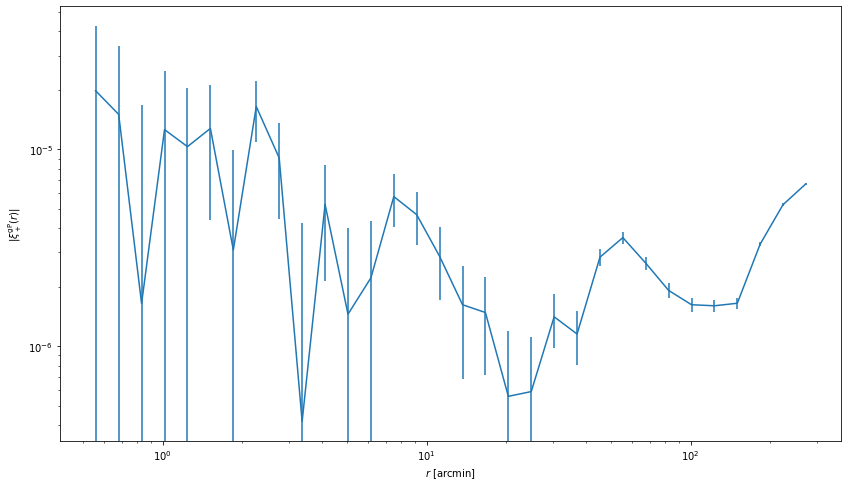

In [55]:
# Create plot with error bars. Error bars are computed by treecorr, and are here shape/shot noise only.
figure(figsize=(14,8))
_ = errorbar(ng.meanr, abs(ng.xip), yerr=np.sqrt(ng.varxip))
loglog()
_ = plt.xlabel(f'$r$ [{sep_units}]')
_ = plt.ylabel(r'$|\xi^{{\rm gP}}_+(r)|$')

# 7th session

2/12/2021

Continue with the scale-dependent leakage function $\alpha(\theta)$.

In [56]:
# Compute the PSF - PSF autocorrelation function.
# The PSF catalogue has already been done last time, so we just have to create a new correlation object
# and process it.

pp = treecorr.GGCorrelation(TreeCorrConfig)
pp.process(cat_psf, cat_psf)

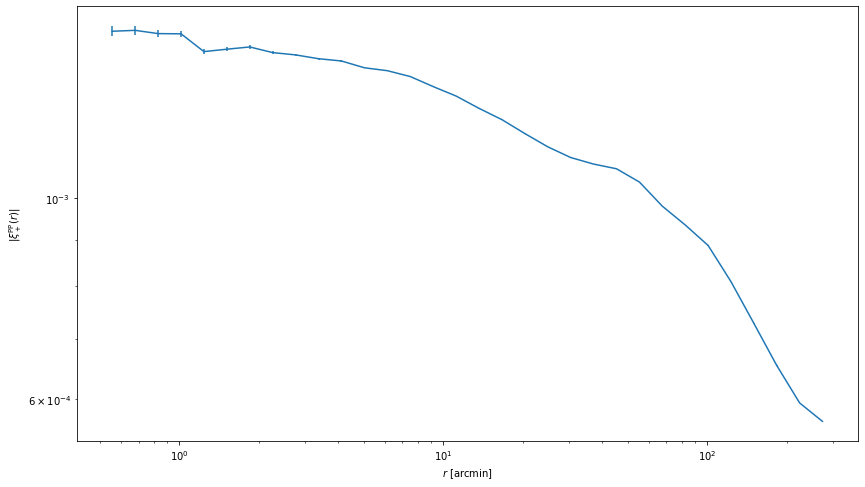

In [57]:
figure(figsize=(14,8))
_ = errorbar(pp.meanr, pp.xip, yerr=np.sqrt(pp.varxip))
_ = plt.loglog()
_ = plt.xlabel(f'$r$ [{sep_units}]')
_ = plt.ylabel(r'$|\xi^{{\rm PP}}_+(r)|$')

In [58]:
# Now compute the average ellipticit values.

# PSF ellipticity, as compex number
psf_g_bar = np.mean(psf_g1 + psf_g2 * 1j)

# Multiply with the galaxy ellipticity (complex conjugated), and take real values (not explicitely
# written in equation)
eg_psf_g_bar = np.real(np.mean((gal_e[:,0] - gal_e[:,1]*1j)) * psf_g_bar)

# Also compute the rms as check
psf_g_rms = np.std(psf_g1 + psf_g2 * 1j)

# RMS is larger than mean, even absolute mean...not sure that this makes much sense, but
# at the moment we ignore this.
print(np.abs(psf_g_bar), psf_g_rms)
print(len(psf_g1))

0.025787581251757917 0.049055675462149784
87687


In [59]:
# Now we have everything together to compute alpha(theta)

alpha = (ng.xip - eg_psf_g_bar) / (pp.xip - np.abs(psf_g_bar)**2)

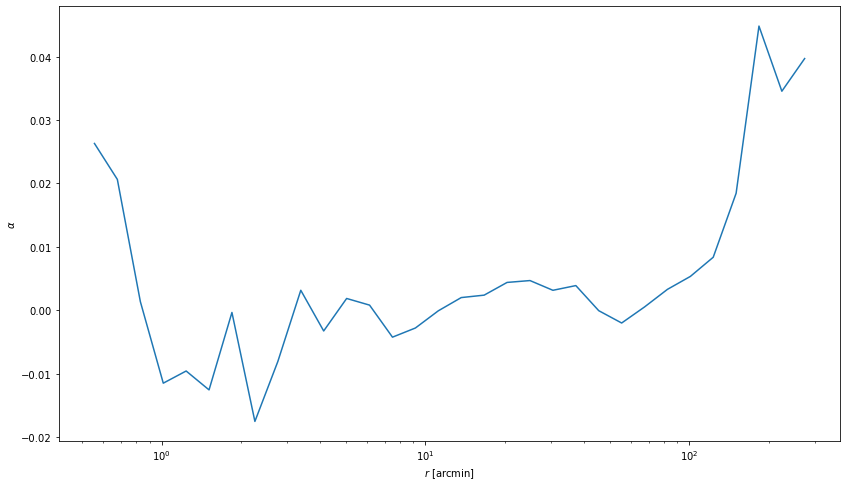

In [60]:
# Plot, without error bars (for that we would need to propagate the errors of all components)

figure(figsize=(14,8))
_ = plot(pp.meanr, alpha)
_ = plt.semilogx()
_ = plt.xlabel(f'$r$ [{sep_units}]')
_ = plt.ylabel(r'$\alpha$')

### Now let's look at Planck clusters!

In [61]:
# There are four SZ clusters in the W3 footprint. Here are the coordinates, from the catalogue
# available at the Planck webpage.

clusters = [(218.83875087412983, 55.14134974316738),
 (216.77906936376968, 55.74970443037433),
 (217.1485398057025, 56.876583531173544),
 (213.6782168416283, 54.783574398561655)]

In [62]:
# Create a catalogue with the cluster positions. No shapes required, since we will correlate CFIS shapes
# with cluster positions.

ra_cl = np.array(clusters)[:,0]
dec_cl = np.array(clusters)[:,1]
w_cl = np.ones_like(ra_cl)

cat_cl = treecorr.Catalog(ra=ra_cl, dec=dec_cl, w=w_cl, ra_units='degrees', dec_units='degrees')

In [63]:
xp = treecorr.NGCorrelation(TreeCorrConfig)
xp.process(cat_cl, cat_gal)


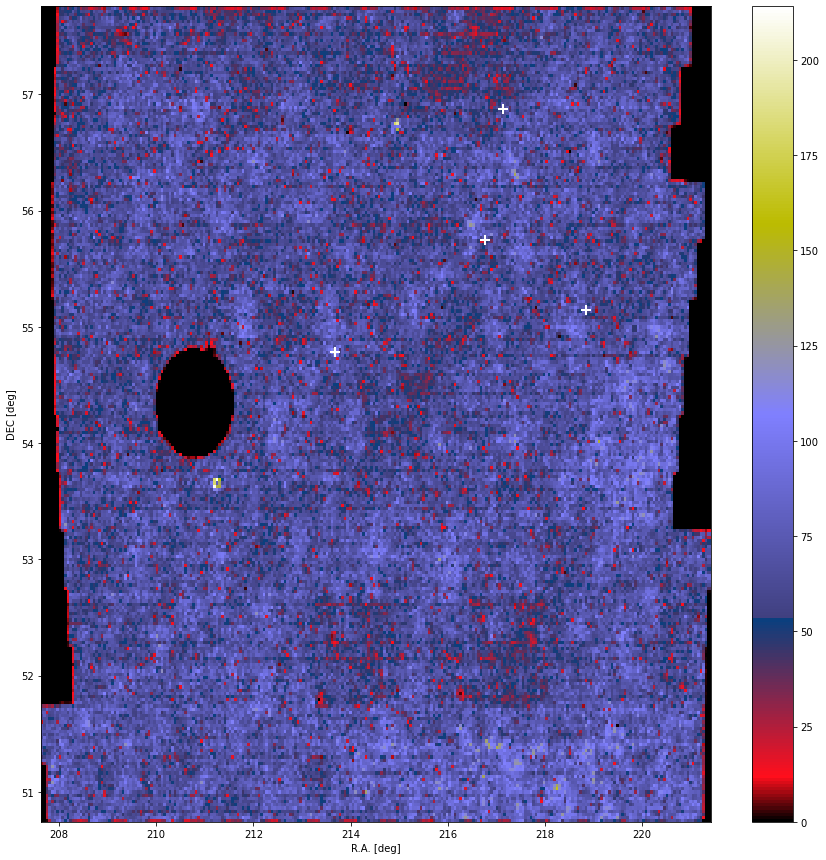

In [64]:
# Plot the cluster positions in the W3 footprint, to make sure they are not in a mask or at the border

figure(figsize=(15, 15))
hist2d(dd['XWIN_WORLD'][mask], dd['YWIN_WORLD'][mask], 256, cmap='gist_stern');
xlabel('R.A. [deg]')
ylabel('DEC [deg]')
plot(ra_cl, dec_cl, 'w+', markersize=10, markeredgewidth=2)
_ = colorbar()

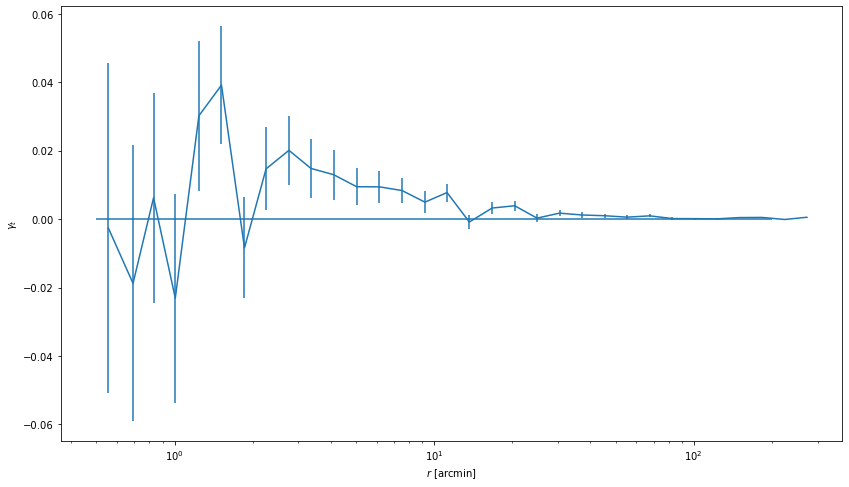

In [65]:
# And voila the plot, with errorbars
# It looks like there is a positive signal!
# This is the mean tangential shear as function of distance to the cluster center.
# In principle (modulo systematics and our many approximations here) this
# is the real weak-lensing distortion signal of CFIS galaxies due of the massive SZ clusters.

figure(figsize=(14,8))
_ = errorbar(xp.meanr, xp.xi, yerr=np.sqrt(xp.varxi))
plt.hlines(y=0, xmin=0.5, xmax=200)
plt.semilogx()
_ = plt.xlabel(f'$r$ [{sep_units}]')
_ = plt.ylabel(r'$\gamma_t$')

# 8th session

09/12/2021


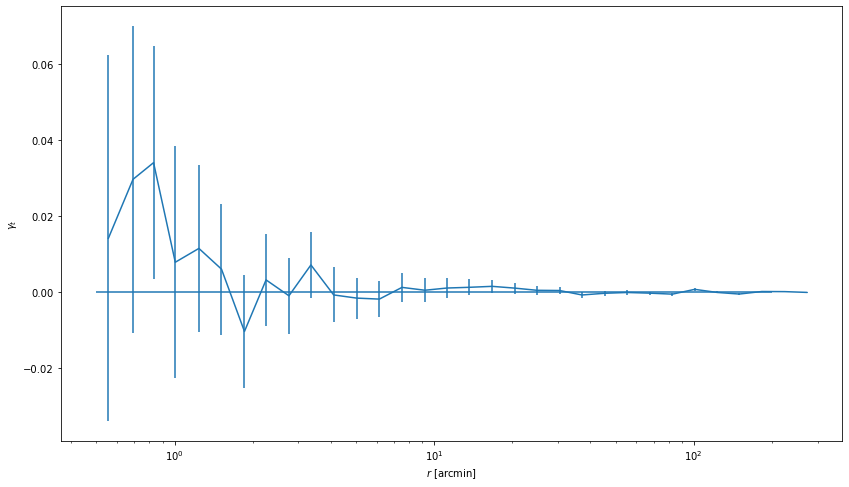

In [66]:
# Plotting the B-mode of the previous plot. It should be consistent with zero.

figure(figsize=(14,8))
_ = errorbar(xp.meanr, xp.xi_im, yerr=np.sqrt(xp.varxi))
plt.hlines(y=0, xmin=0.5, xmax=200)
plt.semilogx()
_ = plt.xlabel(f'$r$ [{sep_units}]')
_ = plt.ylabel(r'$\gamma_t$')


In [67]:
# Galaxy density (number of gal / arcmin^2)
ngal = 6
# Galaxy shape noise (~ 0.3 < sigma_ep < 0.4)
sigma_ep = np.sqrt(np.mean(gal_e[:,0]**2 + gal_e[:,1]**2))

# Area in arcmin^2
area = np.pi * 100**2 
# Number of background densitites
nb_bk_gal = area * ngal

# Noise 
noise_calc = sigma_ep / np.sqrt(nb_bk_gal * 3e3) *(1/np.sqrt(2))
noise_calc


1.0725777321253956e-05

In [68]:
# S/N estimation
signal = 6.7e-5

SN = signal / noise_calc
SN

6.246633506667561

In [69]:
# Load SDSS catalog and randoms
sdss_cat = np.loadtxt('./data/sdssgroup_cfis.dat')
random_cfis_cat = np.loadtxt('./data/random_cfis.dat')
axel_random = np.load('./data/w3_randoms.npy')


/Users/tliaudat/opt/anaconda3/envs/WF_PSF/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


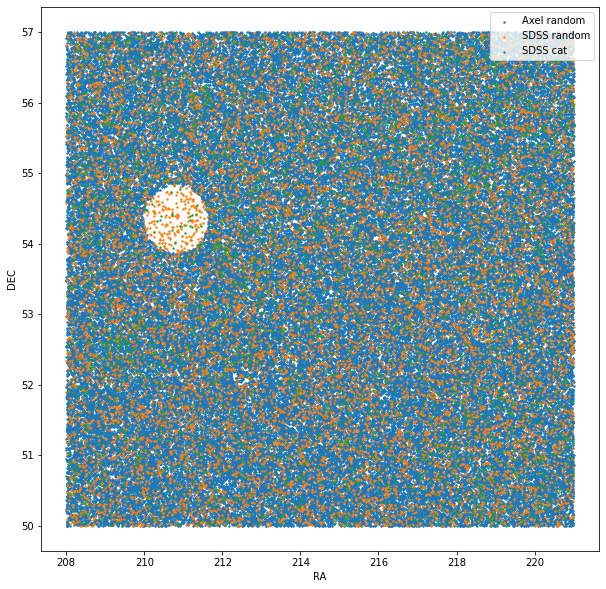

In [70]:
plt.figure(figsize=(10,10))
plt.scatter(axel_random['ra'], axel_random['dec'], s=2, label='Axel random')
plt.scatter(random_cfis_cat[:,0], random_cfis_cat[:,1], s=2, label='SDSS random')
plt.scatter(sdss_cat[:,0], sdss_cat[:,1], s=2, label='SDSS cat')
plt.legend()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()


In [71]:
# Max and min RA,DEC on the SDSS footprint
ra_min = np.min(sdss_cat[:,0])
ra_max = np.max(sdss_cat[:,0])

dec_min = np.min(sdss_cat[:,1])
dec_max = np.max(sdss_cat[:,1])

print('RA: \t', ra_min, ra_max)
print('DEC: \t', dec_min, dec_max)


RA: 	 208.00329746 220.999885828
DEC: 	 50.000595057 56.997399792


## 9th session: Mass-Map (1/3)

13/01/2022

We first start to compute the mass-map assuming a cartesian grid and without making cuts and calibration...

Requirement: [lenspack](https://github.com/CosmoStat/lenspack)
```
pip install lenspack
```

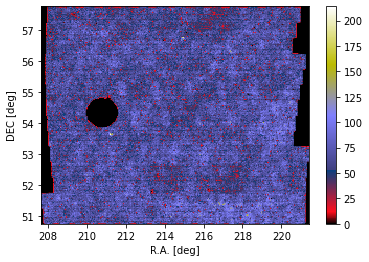

In [72]:
hist2d(dd['XWIN_WORLD'][mask], dd['YWIN_WORLD'][mask], 256, cmap='gist_stern');
xlabel('R.A. [deg]')
ylabel('DEC [deg]')
_ = colorbar()

Bin ellipticity catalog on map with given pixel size

In [73]:
from lenspack.utils import bin2d
from lenspack.image.inversion import ks93, ks93inv
from lenspack.peaks import find_peaks2d

resolution = 2. # arcmin/pixel
widthx = 500
widthy = 350
sizex = widthx * resolution / 60.
sizey = widthy * resolution / 60.

ra = median(dd['XWIN_WORLD'][mask])
dec = median(dd['YWIN_WORLD'][mask])
extent = [ra - sizex/2, ra + sizex/2, dec - sizey/2, dec + sizey/2]

In [74]:
# Bin ellipticity components based on galaxy position
e1map, e2map = bin2d(dd['XWIN_WORLD'][mask], dd['YWIN_WORLD'][mask], 
                     v=(dd['NGMIX_ELL_NOSHEAR'][:,0][mask], dd['NGMIX_ELL_NOSHEAR'][:,1][mask]), 
                     # w=cat_full['nhweight_int'],
                     npix=(widthx, widthy),
                     extent=extent)

In [75]:
# number of galaxies per pixel
n_gal_map = bin2d(dd['XWIN_WORLD'][mask], dd['YWIN_WORLD'][mask], 
                     npix=(widthx, widthy),
                     extent=extent)

In [76]:
from lenspack.geometry.projections import gnom

def get_extend_radec(res, width):
    ra0, dec0 = (ra, dec) # from cosmos.astro.caltech.edu (could also just use the medians of positions)
    proj = gnom.projector(ra0, dec0)
    pix_size = res #arcmin
    dx = np.deg2rad(width*pix_size/60./2) # number of degrees across
    dy = dx
    extent_xy = [-dx, dx, -dy, dy]
    ra_min, dec_min = proj.xy2radec(-dx, -dy)
    ra_max, dec_max = proj.xy2radec(dx, dy)
    extent_radec = [ra_min, ra_max, dec_min, dec_max]
    return extent_radec

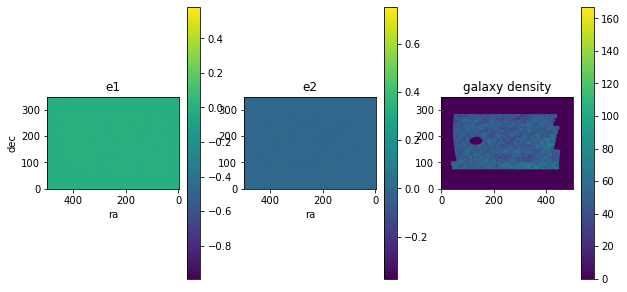

In [77]:
figure(figsize=[10,5])
subplot(131)
imshow(e1map, origin='lower')#, extent=get_extend_radec(resolution, width))
xlim(gca().get_xlim()[::-1])
xlabel('ra')
ylabel('dec')
title('e1')
colorbar()

subplot(132)
imshow(e2map, origin='lower')#, extent=get_extend_radec(resolution, width))
xlim(gca().get_xlim()[::-1])
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
title('e2')
colorbar()

subplot(133)
imshow(n_gal_map, origin='lower')
title('galaxy density')
colorbar()

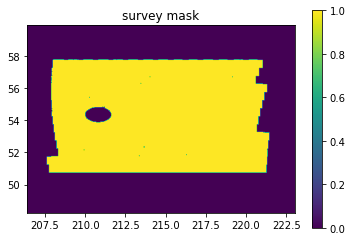

In [78]:
# survey mask
m = n_gal_map == 0.
imshow(1-m, origin='lower', extent=extent)
title('survey mask')
colorbar()

In [79]:
# average number of galaxies per pixel
print('Avg number of gal per pixel:', np.mean(n_gal_map[np.logical_not(m)]))
print('Avg number of gal per arcmin^2:', np.mean(n_gal_map[np.logical_not(m)])/resolution/resolution)

Avg number of gal per pixel: 48.92533721043886
Avg number of gal per arcmin^2: 12.231334302609715


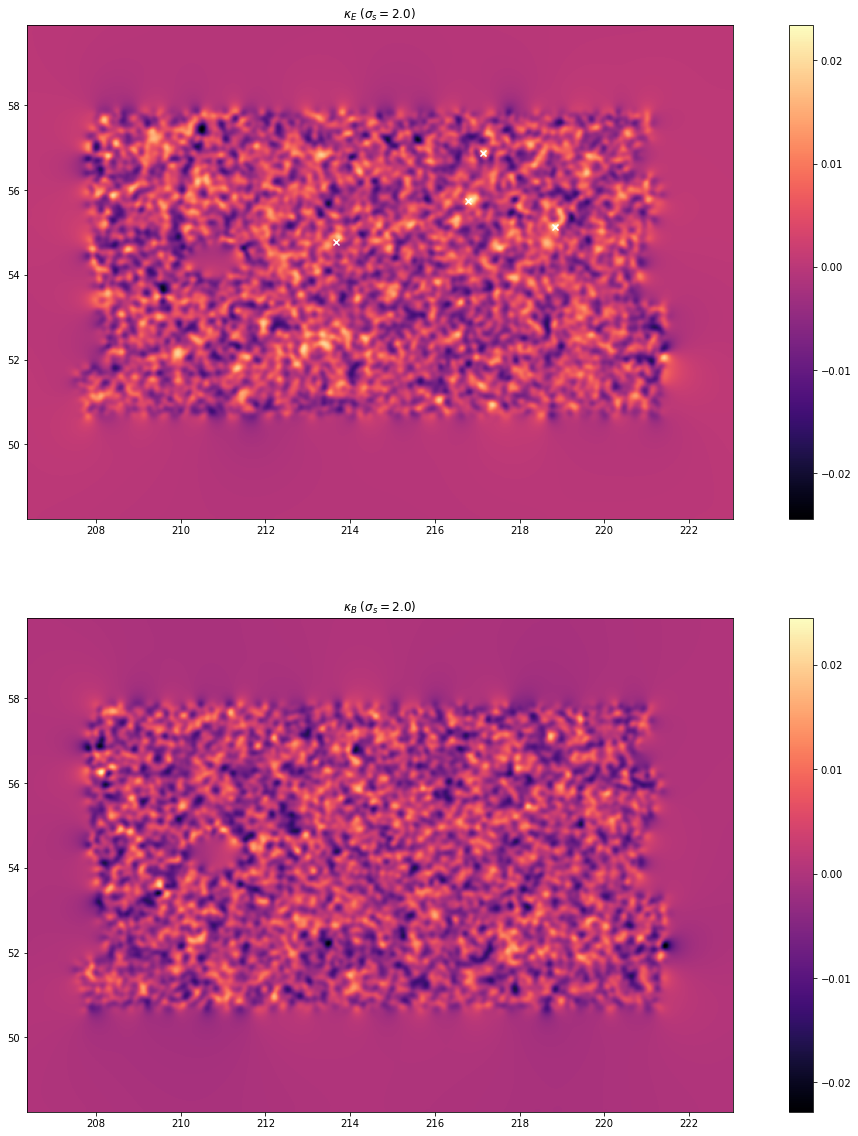

In [80]:
# Performs a standard KS reconstruction
kappaE, kappaB = ks93(e1map, -e2map) 

from scipy.ndimage import gaussian_filter

kwargs = dict(cmap='magma', origin='lower')#, vmax=0.01, vmin=-0.0)

smoothing = 2.

figure(figsize=[20,20])
subplot(211)
imshow(gaussian_filter(kappaE,smoothing), **kwargs, extent=extent)#,vmax=0.05,vmin=-0.1);``
title(r'$\kappa_E$ ($\sigma_s={}$)'.format(smoothing))
colorbar();
scatter(ra_cl, dec_cl, marker='x',color='white')
subplot(212)
imshow(gaussian_filter(kappaB,smoothing), **kwargs, extent=extent)
title(r'$\kappa_B$ ($\sigma_s={}$)'.format(smoothing))
colorbar();

## 10th session: Mass-Map (2/3)

20/01/2022

To compute correctly the mass-map we need to consider the following pipeline:

0. recompute the SNR
1. select the shape sample (SNR, size cuts)
2. shear calibration (shape measurement, selection)
3. take into account the spherical coordinates (healpix)

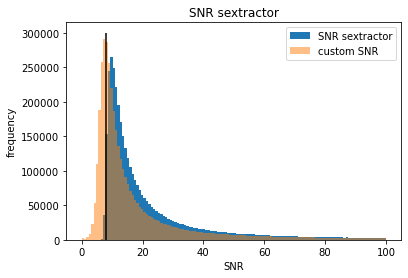

In [81]:
# There are two SNR estimates. One from SExtractor (``SNR_WIN``),
# one from ngmix (ratio of fitted flux divided by flux error).
# Plot both histograms to compare.

hist(dd['SNR_WIN'][mask], range=(0,100), bins=128, label='SNR sextractor');
title('SNR sextractor')
_ = xlabel('SNR')
_ = ylabel('frequency')

SNR2 = dd['NGMIX_FLUX_NOSHEAR'][mask] / dd['NGMIX_FLUX_ERR_NOSHEAR'][mask]
hist(SNR2, range=(0,100), bins=128, alpha=.5, label='custom SNR');

# Line at SNR=8 where we might want to cut (empirically)
vlines(8, ymin=0, ymax=300000, color='k')
legend()

In [82]:
# Define the cut
snr_cut = (dd['NGMIX_FLUX_NOSHEAR'] / dd['NGMIX_FLUX_ERR_NOSHEAR']) > 8.

In [83]:
# Refine the mask from a few sessions ago, to remove invalid objects.
# Add PSF flag, which indicates problems with the PSF computation.

mask = (dd['FLAG_TILING'] == 1) & (dd['FLAGS'] == 0) & (dd['IMAFLAGS_ISO'] == 0) & \
        (dd['NGMIX_FLAGS_NOSHEAR'] == 0) &  (dd['NGMIX_MCAL_FLAGS'] == 0) \
        & (dd['NGMIX_ELL_PSFo_NOSHEAR'][:,0] != -10) # 

In [84]:
# Combin all previous masks
selection_mask = mask & mask_spread_mod & size_mask & snr_cut

### Selection bias from metacal

Response matrix of the selection bias:

$$<R_{ij}^S> = \frac{<e_i>^{0,M+}-<e_i>^{0,M-}}{2|\gamma_j|}$$

- $e_i$ indicates which composant of the ellipticity is considered
- $\gamma_j$ indicates which composant of the shear is applied
- $0$ indicates that we apply the mask on the non sheared ellipticities
- $M+/-$ indicates whether the mask is computed from the + or - sheared ellipticities

In [85]:
dg = 0.01
snr_cut_t = 8. # SNR cut threshold

# First, we apply the SNR and size cuts on the sheared objects

# shear +
e1p_snr = (dd['NGMIX_FLUX_1P'] / dd['NGMIX_FLUX_ERR_1P']) > snr_cut_t # SNR cut
e1p_size = (dd['NGMIX_T_1P'] / dd['NGMIX_Tpsf_1P']) > 0.5 # size cut

# Combine these two selections with the previous (general galaxy) masks
selection_mask_e1p = mask & e1p_snr & e1p_size & mask_spread_mod

# Compute mean ellipticity of the *unsheared* catalogue, but with the above
# selection on the sheared objects
e1p_masked = np.mean(dd['NGMIX_ELL_NOSHEAR'][:,0][selection_mask_e1p])

# The same for the negative shear
# shear -
e1m_snr = (dd['NGMIX_FLUX_1M'] / dd['NGMIX_FLUX_ERR_1M']) > snr_cut_t # SNR cut
e1m_size = (dd['NGMIX_T_1M'] / dd['NGMIX_Tpsf_1M']) > 0.5 # size cut

selection_mask_e1m = mask & e1m_snr & e1m_size & mask_spread_mod

e1m_masked = np.mean(dd['NGMIX_ELL_NOSHEAR'][:,0][selection_mask_e1m])

# The selection response matrix (element) is now just the difference between
# the mean ellipticity of the sample with the two masks applied.
R11_S = (e1p_masked - e1m_masked) / (2 * dg)
print('R_11^S =', R11_S)

/Users/tliaudat/opt/anaconda3/envs/WF_PSF/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


R_11^S = 0.01547884692709464


/Users/tliaudat/opt/anaconda3/envs/WF_PSF/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [86]:
# Note: This is an order of magnitude smaller than what we have seen before in W3. This is due to the fact
# that previously we corrected the object size with itss ellipticity. This introduced a correlation between
# this cut and the shear, which was reflected in a stronger selection bias.
# The size in this notebook here is much less correlated with shear.

In [87]:
print('M+ size:', np.sum(selection_mask_e1p))
print('e_1^M- =', e1m_masked)

M+ size: 2203701
e_1^M- = -0.0005801200609548511


In [88]:
# R21

dg = 0.01
snr_cut_t = 8. # SNR cut threshold

# shear +
e1p_snr = (dd['NGMIX_FLUX_1P'] / dd['NGMIX_FLUX_ERR_1P']) > snr_cut_t # SNR cut
e1p_size = (dd['NGMIX_T_1P'] / dd['NGMIX_Tpsf_1P']) > 0.5 # size cut

selection_mask_e1p = mask & e1p_snr & e1p_size & mask_spread_mod

e2p_masked = np.mean(dd['NGMIX_ELL_NOSHEAR'][:,1][selection_mask_e1p])

# shear -
e1m_snr = (dd['NGMIX_FLUX_1M'] / dd['NGMIX_FLUX_ERR_1M']) > snr_cut_t # SNR cut
e1m_size = (dd['NGMIX_T_1M'] / dd['NGMIX_Tpsf_1M']) > 0.5 # size cut

selection_mask_e1m = mask & e1m_snr & e1m_size & mask_spread_mod

e2m_masked = np.mean(dd['NGMIX_ELL_NOSHEAR'][:,1][selection_mask_e1m])

R21_S = (e2p_masked - e2m_masked) / (2 * dg)
print('R_21^S =', R21_S)

/Users/tliaudat/opt/anaconda3/envs/WF_PSF/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


R_21^S = 0.0006011848971913705


/Users/tliaudat/opt/anaconda3/envs/WF_PSF/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [89]:
# R12

dg = 0.01
snr_cut_t = 8. # SNR cut threshold

# shear +
e2p_snr = (dd['NGMIX_FLUX_2P'] / dd['NGMIX_FLUX_ERR_2P']) > snr_cut_t # SNR cut
e2p_size = (dd['NGMIX_T_2P'] / dd['NGMIX_Tpsf_2P']) > 0.5 # size cut

selection_mask_e2p = mask & e2p_snr & e2p_size & mask_spread_mod

e1p_masked = np.mean(dd['NGMIX_ELL_NOSHEAR'][:,0][selection_mask_e2p])

# shear -
e2m_snr = (dd['NGMIX_FLUX_2M'] / dd['NGMIX_FLUX_ERR_2M']) > snr_cut_t # SNR cut
e2m_size = (dd['NGMIX_T_2M'] / dd['NGMIX_Tpsf_2M']) > 0.5 # size cut

selection_mask_e2m = mask & e2m_snr & e2m_size & mask_spread_mod

e1m_masked = np.mean(dd['NGMIX_ELL_NOSHEAR'][:,0][selection_mask_e2m])

R12_S = (e1p_masked - e1m_masked) / (2 * dg)
print('R_12^S =', R12_S)

/Users/tliaudat/opt/anaconda3/envs/WF_PSF/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


R_12^S = -0.002291845640016698


/Users/tliaudat/opt/anaconda3/envs/WF_PSF/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


## 11th session: Mass-Map (3/3)

12/02/2022

In [90]:
# TODO: use healpix for spherical coordinates
import healpy as hp

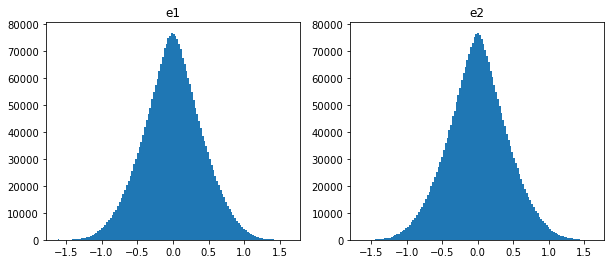

In [91]:
# shear calibration
e1 = dd['NGMIX_ELL_NOSHEAR'][mask_spread_mod][:,0]
e2 = dd['NGMIX_ELL_NOSHEAR'][mask_spread_mod][:,1]
e = np.linalg.inv(R_gal) @ np.stack([e1,e2], axis=0)

figure(figsize=(10,4))

subplot(121)
title('e1')
hist(e[0], bins=128);

subplot(122)
title('e2')
hist(e[1], bins=128);

In [92]:
ra = dd['XWIN_WORLD'][mask_spread_mod]
dec = dd['YWIN_WORLD'][mask_spread_mod]
g1 = e[0]
g2 = e[1]

print(ra.shape)

(2853441,)


In [93]:
def eq2ang(ra, dec):
    """
    convert equatorial ra,dec in degrees to angular theta, phi in radians
    parameters
    ----------
    ra: scalar or array
        Right ascension in degrees
    dec: scalar or array
        Declination in degrees
    returns
    -------
    theta,phi: tuple
        theta = pi/2-dec*D2R # in [0,pi]
        phi   = ra*D2R       # in [0,2*pi]
    """
    dec = dec*np.pi/180
    ra  = ra*np.pi/180
    theta = np.pi/2 - dec
    phi  = ra
    return theta, phi

def bin_shear_map(ra, dec, g1, g2, nside, hp_type='RING'):
    """
    Computes the shear map by binning the catalog according to pixel_index.
    Either nx,ny or npix must be provided.
    Parameters
    ----------
    catalog: table
        Input shape catalog with pixel_index column
    nx,ny: int, optional
        Number of pixels of a 2d flat map
    npix: int, optional
        Number of pixels of a spherical map (or other 1D pixelating scheme)
    Returns
    -------
    gmap: ndarray
        Shear map
    nmap: ndarray
        Number of galaxies per pixels
    """
    #assert (npix is not None) or ((nx is not None) and (ny is not None))
    
    theta, phi = eq2ang(ra, dec)
    pixel_index = hp.ang2pix(nside, theta, phi,
                             nest=(hp_type=='NESTED'))

    # Bin the shear catalog
    npix=hp.nside2npix(nside)

    g1map = np.bincount(pixel_index,
                        weights=g1,
                        minlength=npix)
    g2map = np.bincount(pixel_index,
                        weights=g2,
                        minlength=npix)
    Nmap  = np.bincount(pixel_index, minlength=npix)

    # Normalize by number of galaxies
    nz_ind = Nmap > 0
    g1map[nz_ind] /= Nmap[nz_ind]
    g2map[nz_ind] /= Nmap[nz_ind]

    gmap = np.stack([g1map,g2map], axis=0)

    return gmap, Nmap

def healpix_KS_map(gmap, lmax=None, sigma=None):
    """
    Computes kappa maps from a given healpix shear map (in ring format)
    Adapted from `g2k_sphere` DES code:
    https://github.com/chihway/massmapping/blob/master/utils/massmapping_utils.py
    Parameters
    ----------
    gmap: ndarray
        Healpix convergence map (ring format)
    lmax: int
        Maximum multipole order
    sigma: float
        Gaussian smoothing applied to the alms [arcmin]
    """
    nside = hp.npix2nside(gmap.shape[1])

    if sigma is not None:
        # convert to radians
        sigma = sigma / 60./180*np.pi

    if lmax is None:
        lmax = 2*nside

    KQU_maps = [np.zeros_like(gmap[0]), gmap[0], gmap[1]]
    alms = hp.map2alm(KQU_maps, lmax=lmax, pol=True)

    ell, emm = hp.Alm.getlm(lmax=lmax)
    almsE = alms[1]*((ell*(ell+1.))/((ell+2.)*(ell-1)))**0.5
    almsB = alms[2]*((ell*(ell+1.))/((ell+2.)*(ell-1)))**0.5
    almsE[ell==0] = 0.0
    almsB[ell==0] = 0.0
    almsE[ell==1] = 0.0
    almsB[ell==1] = 0.0

    E_map = hp.alm2map(almsE, nside=nside, lmax=lmax, pol=False, sigma=sigma, verbose=False)
    B_map = hp.alm2map(almsB, nside=nside, lmax=lmax, pol=False, sigma=sigma, verbose=False)
    return E_map, B_map

In [94]:
# nside = 2048
nside = 1024
lmax = 2*nside

gmap, Nmap = bin_shear_map(ra, dec, -g1, g2, nside)
E_map, B_map = healpix_KS_map(gmap, lmax=lmax, sigma=8)

/Users/tliaudat/opt/anaconda3/envs/WF_PSF/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/Users/tliaudat/opt/anaconda3/envs/WF_PSF/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in multiply
/Users/tliaudat/opt/anaconda3/envs/WF_PSF/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in true_divide
/Users/tliaudat/opt/anaconda3/envs/WF_PSF/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in multiply


In [95]:
mask_pix = Nmap.copy()
mask_pix[mask_pix>0] = 1

/Users/tliaudat/opt/anaconda3/envs/WF_PSF/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  
/Users/tliaudat/opt/anaconda3/envs/WF_PSF/lib/python3.6/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  newcm.set_over(newcm(1.0))
/Users/tliaudat/opt/anaconda3/envs/WF_PSF/lib/python3.6/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versio

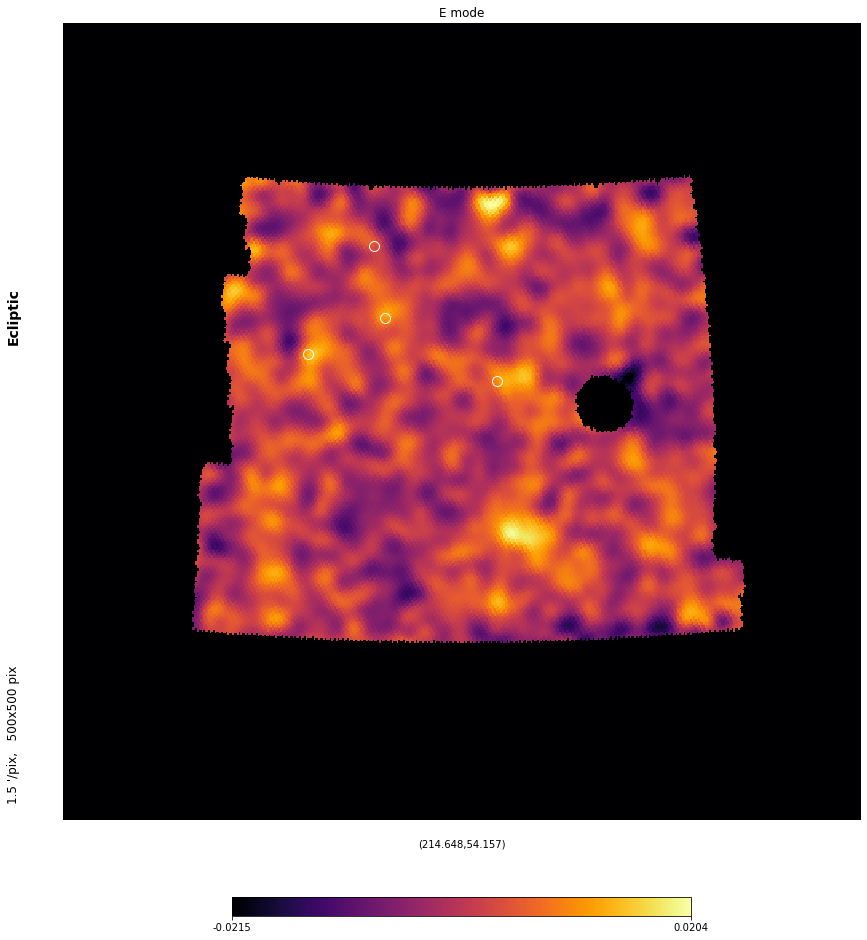

In [96]:
cmap = plt.cm.get_cmap('inferno')
cmap.set_under(color='black')

ra_center = np.mean(ra)
dec_center = np.mean(dec)

vmin = (E_map).min()
vmax = (E_map).max()

E_mode_map = E_map.copy()
E_mode_map[mask_pix==0] = -10

fig = plt.figure(figsize=(15,15))
hp.gnomview(E_mode_map, coord=['E', 'E'], 
            rot=[ra_center, dec_center], xsize=500, ysize=500, 
            fig=1, title="E mode", cmap=cmap, min=vmin, max=vmax)


clusters = np.array(clusters)
hp.projplot(clusters[:,0], clusters[:,1], coord=['E', 'E'], 
            lonlat=True, marker='o', linestyle='', fillstyle='none', 
            color="white", markersize=10);

/Users/tliaudat/opt/anaconda3/envs/WF_PSF/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  


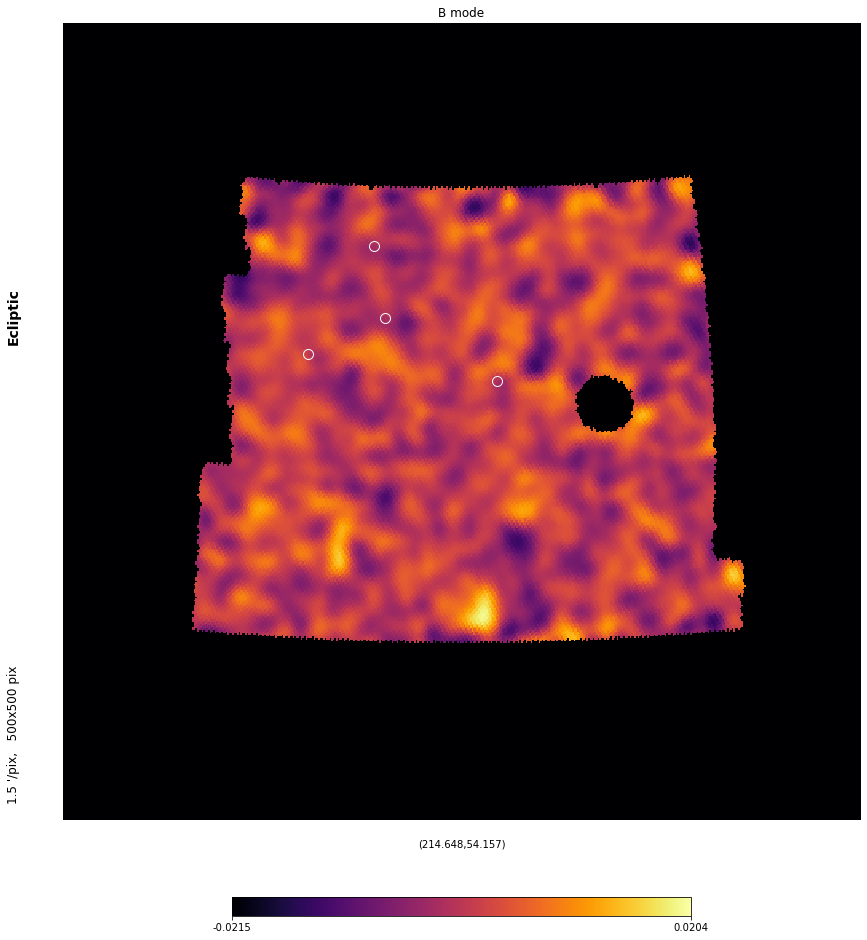

In [97]:
cmap = plt.cm.get_cmap('inferno')
cmap.set_under(color='black')

ra_center = np.mean(ra)
dec_center = np.mean(dec)

#vmin = (B_map).min()
#vmax = (B_map).max()

B_mode_map = B_map.copy()
B_mode_map[mask_pix==0] = -10

fig = plt.figure(figsize=(15,15))
hp.gnomview(B_mode_map, coord=['E', 'E'], 
            rot=[ra_center, dec_center], xsize=500, ysize=500, 
            fig=1, title="B mode", cmap=cmap, min=vmin, max=vmax)


clusters = np.array(clusters)
hp.projplot(clusters[:,0], clusters[:,1], coord=['E', 'E'], 
            lonlat=True, marker='o', linestyle='', fillstyle='none', 
            color="white", markersize=10);

In [98]:
"Average number of galaxies per pixel:", np.mean(Nmap[Nmap!=0])

('Average number of galaxies per pixel:', 172.59063690800218)

## 12th session: photo-z

17/02/2022

In [197]:

multi_band_data_path = './multi-band_UNIONS/CFIS_matched_alldeep_catalog_lephare_RIZGY.csv'

mb_data = np.genfromtxt(multi_band_data_path, delimiter=',', skip_header=1)
mb_headers = ['ID',
              'Z_SPEC',
              'MAG_AUTO_Z',
              'MAG_AUTO_Y',
              'MAG_AUTO_R', # This band is actually ok
              'MAG_AUTO_I',
              'MAG_AUTO_G',
              'MAGERR_AUTO_Z',
              'MAGERR_AUTO_Y',
              'MAGERR_AUTO_R',
              'MAGERR_AUTO_I',
              'MAGERR_AUTO_G']
# (1971, 12)
# Need to substract 5 to each MAG band except for the R band
mb_data[:,2:4] -= 5.
mb_data[:,5:7] -= 5.


Mean redshift:  0.5909132008488401
Median redshift:  0.5482204556465149


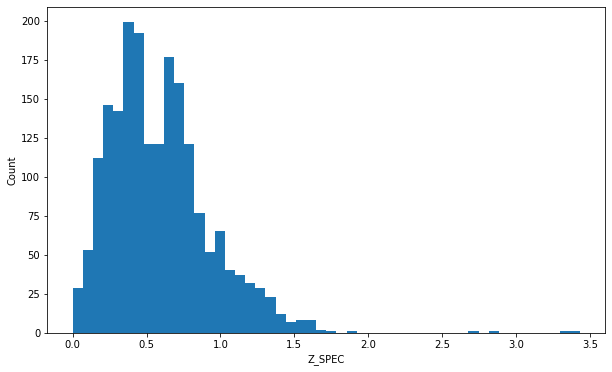

In [206]:

# Redshift distribution
figure(figsize=(10,6))
_ = plt.hist(mb_data[:,1],bins=50)
_ = plt.xlabel(mb_headers[1])
_ = plt.ylabel('Count')

print('Mean redshift: ', np.mean(mb_data[:,1]))
print('Median redshift: ', np.median(mb_data[:,1]))


In [204]:
# Check for outliers in the magnitude's range
print(np.max(mb_data[:,2:6]))
print(np.min(mb_data[:,2:6]))


27.396743774414062
17.356597900390625


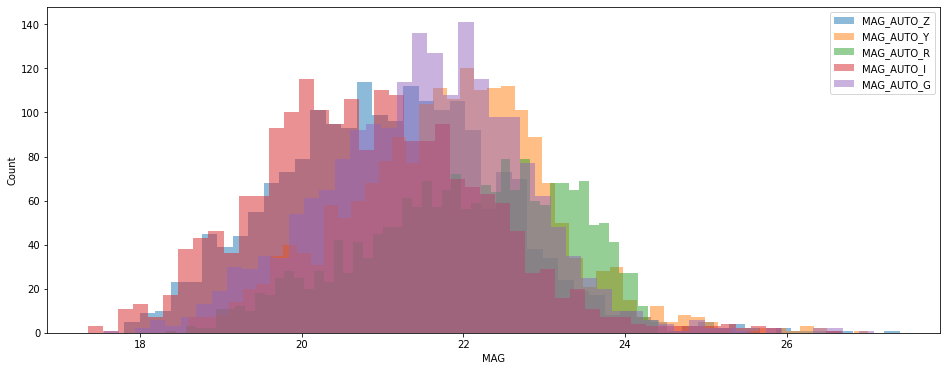

In [207]:
# Plot the magnitude distribution in the differente bands
figure(figsize=(16,6))
_= plt.hist(mb_data[:,2],bins=50, alpha=0.5, label=mb_headers[2])
_= plt.hist(mb_data[:,3],bins=50, alpha=0.5, label=mb_headers[3])
_= plt.hist(mb_data[:,4],bins=50, alpha=0.5, label=mb_headers[4])
_= plt.hist(mb_data[:,5],bins=50, alpha=0.5, label=mb_headers[5])
_= plt.hist(mb_data[:,6],bins=50, alpha=0.5, label=mb_headers[6])
plt.legend()
_ = plt.xlabel('MAG')
_ = plt.ylabel('Count')


In [208]:
# Let's try to  estimate the photo-z from the magnitudes

import tensorflow as tf
import tensorflow.keras as keras
from sklearn.preprocessing import StandardScaler


In [209]:
# First we scale our data
# We remove the mean and scale to unit variance 

# Build the train and testing datasets
x_train = mb_data[:,2:7]
y_train = mb_data[:,1]

scaler = StandardScaler()
scaler.fit(x_train)
print(scaler.mean_)
std_x_train = scaler.transform(x_train)




[21.10465128 21.84058263 22.02903631 20.85286693 21.53829413]


In [154]:
print(std_x_train.shape)
print(y_train.shape)

(1971, 5)
(1971,)


In [210]:
# We train a fully connected neural network in a supervised way


learning_rate=1e-3
decay=1e-6

input_channels =std_x_train.shape[1]

# Model definition
l2_model = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu', input_shape=(input_channels,)),
    keras.layers.Dense(units=128, activation='tanh'),
    keras.layers.Dense(units=1)
])

opt = keras.optimizers.Adam(lr=learning_rate, decay=decay)
l2_model.compile(loss='mean_squared_error', optimizer=opt)


# Train the model
history = l2_model.fit(std_x_train, y_train, batch_size=256, epochs=20)



Epoch 1/20
8/8 [==============================] - 0s 2ms/step - loss: 0.2822
Epoch 2/20
8/8 [==============================] - 0s 946us/step - loss: 0.1507
Epoch 3/20
8/8 [==============================] - 0s 864us/step - loss: 0.1169
Epoch 4/20
8/8 [==============================] - 0s 892us/step - loss: 0.0933
Epoch 5/20
8/8 [==============================] - 0s 879us/step - loss: 0.0849
Epoch 6/20
8/8 [==============================] - 0s 930us/step - loss: 0.0822
Epoch 7/20
8/8 [==============================] - 0s 907us/step - loss: 0.0801
Epoch 8/20
8/8 [==============================] - 0s 1ms/step - loss: 0.0792
Epoch 9/20
8/8 [==============================] - 0s 1ms/step - loss: 0.0789
Epoch 10/20
8/8 [==============================] - 0s 1ms/step - loss: 0.0781
Epoch 11/20
8/8 [==============================] - 0s 1ms/step - loss: 0.0781
Epoch 12/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0775
Epoch 13/20
8/8 [==============================] - 0s 1ms/ste

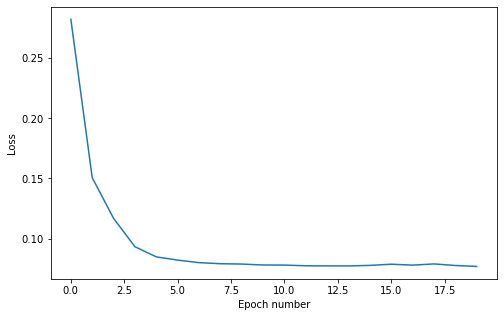

In [212]:

figure(figsize=(8,5))
plot(history.history['loss'])
_ = plt.xlabel('Epoch number')
_ = plt.ylabel('Loss')


In [213]:
# Evaluate the regression model on the testing set
preds = l2_model.predict(std_x_train)


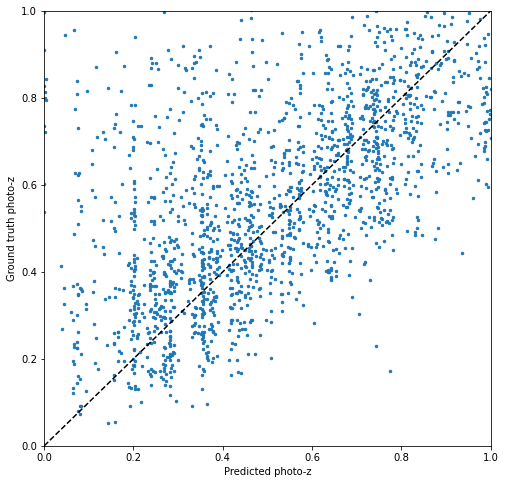

In [219]:
straight_line = np.linspace(0,1,50)

# Plot the results
figure(figsize=(8,8))
plt.plot(straight_line, straight_line, '--k')
plt.scatter(y_train, preds, s=6)
plt.xlim([0,1])
plt.ylim([0,1])
_ = plt.xlabel('Predicted photo-z')
_ = plt.ylabel('Ground truth photo-z')


In [220]:
# We switch to probabilistic modelling

import tensorflow.keras as keras
import tensorflow_probability as tfp


In [221]:
tf.__version__

'2.3.1'

The first thing we need is a parametric model for the distribution $q_{\varphi}(y|x)$ that the model will be predicting. Where $x$ is the input (or magnitudes) of our model and $y$ the output (or photo-z).
A simple approach to build a flexible distribution is to use a Gaussian Mixture Density. With TensorFlow Probability this is easily done by adding a `tfp.layers.MixtureNormal` as the last layer of the model.

The model now outputs a probability distribution object. In fact, it output the parameters of the parametric model of the distribution $q_{\varphi}(y|x)$.

This distribution object can be used to sample from the model, or evaluate the log probability of the model.


In [224]:

learning_rate=1e-3
decay=1e-6
# Number of components in the Gaussian Mixture
num_components = 16

input_channels =std_x_train.shape[1]

# Shape of the distribution
event_shape = [1]

# Utility function to compute how many parameters this distribution requires
params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)

gmm_model = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu', input_shape=(input_channels,)),
    keras.layers.Dense(units=128, activation='tanh'),
    keras.layers.Dense(params_size),
    tfp.layers.MixtureNormal(num_components, event_shape)
])

# Note that Keras will call this loss function with two arguments, the data
# point y, and the distribution q(y | x) predicted as the output of the model
negloglik = lambda y, q: -q.log_prob(y)

opt = keras.optimizers.Adam(lr=learning_rate, decay=decay)
gmm_model.compile(loss=negloglik, optimizer=opt)


history = gmm_model.fit(std_x_train, y_train, batch_size=256, epochs=30)



Epoch 1/30
8/8 [==============================] - 0s 2ms/step - loss: 0.8119
Epoch 2/30
8/8 [==============================] - 0s 1ms/step - loss: 0.5805
Epoch 3/30
8/8 [==============================] - 0s 1ms/step - loss: 0.3751
Epoch 4/30
8/8 [==============================] - 0s 1ms/step - loss: 0.2159
Epoch 5/30
8/8 [==============================] - 0s 1ms/step - loss: 0.0971
Epoch 6/30
8/8 [==============================] - 0s 1ms/step - loss: 0.0293
Epoch 7/30
8/8 [==============================] - 0s 2ms/step - loss: 0.0733
Epoch 8/30
8/8 [==============================] - 0s 2ms/step - loss: -0.0407
Epoch 9/30
8/8 [==============================] - 0s 2ms/step - loss: -0.0467
Epoch 10/30
8/8 [==============================] - 0s 2ms/step - loss: -0.0783
Epoch 11/30
8/8 [==============================] - 0s 2ms/step - loss: -0.1107
Epoch 12/30
8/8 [==============================] - 0s 2ms/step - loss: -0.1218
Epoch 13/30
8/8 [==============================] - 0s 2ms/step - los

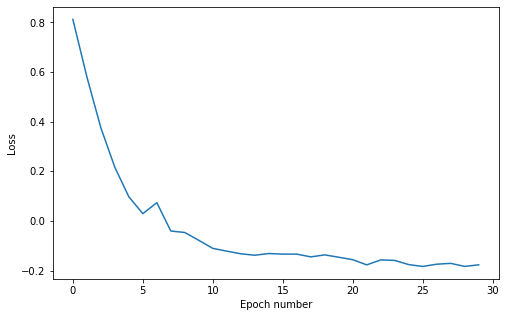

In [226]:

figure(figsize=(8,5))
plot(history.history['loss'])
_ = plt.xlabel('Epoch number')
_ = plt.ylabel('Loss')


In [242]:
# Find the mode by sampling the pdf
x_smpl = linspace(0., 1., 50)

# We evaluate the log probability of the model at different points, to sample the pdf of
# each example
preds = np.stack([gmm_model(std_x_train).log_prob(x).numpy() for x in x_smpl])
mode = x_smpl[preds.argmax(axis=0)]


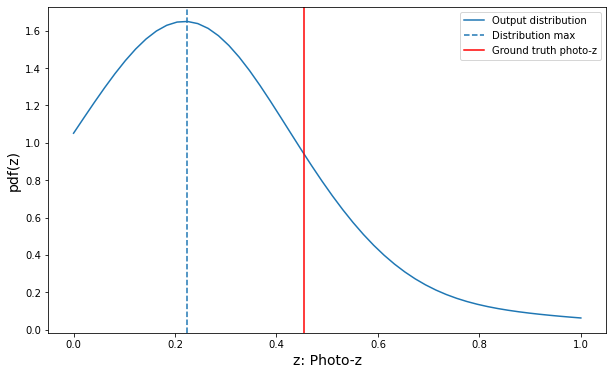

In [253]:
# We can also have a look at individual example pdfs
ex_id = 1

figure(figsize=(10,6))
plot(x_smpl, exp(preds[:,ex_id]), label='Output distribution')
axvline(mode[ex_id], ls='--', label='Distribution max')
axvline(y_train[ex_id], c='red', label='Ground truth photo-z')
plt.legend()
_ = plt.xlabel('z: Photo-z', fontsize=14)
_ = plt.ylabel('pdf(z)', fontsize=14)

